# Project Integration

For our project we will implement logistic regression and train it to classify locations of high poverty and low poverty using satellite imagery of Uganda. This will be a complete machine learning experiment, using a training, validation, and testing set, so we will implement cross validation as well.

# Set Up

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import sys
#your path to the project folder
# dep_path = '/content/drive/MyDrive/AI4ALL2021CV/Computer Vision 2021/Project/'
# dep_path = '/content/drive/MyDrive/Colab Images/dependencies/dependencies' #Ani's path (comment out this entire line and add ur own directory when u are working on the notebook)
# dep_path = '/content/drive/.shortcut-targets-by-id/1qowSaXNfY471t4hwR2bGI8dPoTCLQeSp/Project' #Krithika's path
# dep_path = '/content/drive/MyDrive/AI4ALL/Project' # Nesara's path
# dep_path = '/content/drive/MyDrive/Stanford AI4ALL/Project' # Kyleen's path

dep_path = '/content/drive/My Drive/Project'

sys.path.append(dep_path)
ROOT_DIR = dep_path

In [ ]:
import numpy as np
from itertools import *
import h5py
import os
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import mode
np.random.seed(0)

# Training Essentials

##Basic Feature Extraction: Histograms


In [ ]:
def image_to_histogram(x, bins, use_hsv):
    """
    Inputs:
    x - a single image.
    bins - the number of bins your histograms should have for each channel
    use_hsv - determines if images are stored in RGB or HSV format.
    
    Returns:
    h - a single histogram. It's shape should be (3 x bins,)
    """
    if use_hsv: # convert an RGB to an HSV function
        x = rgb_to_hsv(x)
    h = np.zeros((3*bins,))
    ## YOUR CODE HERE (DONE)
    x0 = x[:,:,0]
    x1 = x[:,:,1]
    x2 = x[:,:,2]

    h[0:bins] = np.histogram(x0, bins, range=(0,1))[0]
    h[bins:2*bins] = np.histogram(x1, bins, range=(0,1))[0]
    h[2*bins:3*bins] = np.histogram(x2, bins, range=(0,1))[0]

    ## END YOUR CODE
    assert h is not None, "You must store a histogram in h!"
    return h

##Basic Model: Logistic Regression

Step 1: Define stochastic/mini batch gradient descent for logistic regression.

In [ ]:
def create_batches(data, labels, batch_size):
    data_batch = np.array_split(data, len(data)/batch_size)
    labels_batch = np.array_split(labels, len(labels)/batch_size)
    return data_batch, labels_batch


def sigmoid(x):
    """
    Given a single value x, return the output of the sigmoid activation function.

    HINT: You can use np.exp(x) function above for e^x
    HINT: The formula for sigmoid can be found on Wikipedia:
          https://en.wikipedia.org/wiki/Sigmoid_function
    """
    ## YOUR CODE HERE (DONE)
    #output = np.exp(x)/(np.exp(x) + 1)
    output = 1/(1+np.exp(-x))
    ## END YOUR CODE
    return output 


def predict_probability(data, weights):
    """
    Use the data and weights to calculate a probability for each data point.
    For example, if "data" has 100 rows, this function should return an array
    with 100 numbers between 0 and 1.

    HINT: "dot products" can be done with np.dot(...)
    HINT: Use the sigmoid function which can be called with s_curve(...)
    HINT: data is of shape (dataset size, num features), and weights is 
    of shape (num features, 1)
    """
    pred = None
    ## YOUR CODE HERE(DONE)
    pred = sigmoid(np.dot(data, weights))
    ## END YOUR CODE
    return pred[...,None]


def sgd(data, labels, weights, learning_rate, regularization_rate):
    """
    Loop over all the data and labels, one at a time, and update the weights using the logistic
    regression learning rule.

    HINT: Logistic regression learning update rule is given by: 
    weights += learning_rate*data[i, :]*(labels[i] - prob)
    weights -= regularization_rate*weights

    HINT: You will need "predict_probability" to complete this function.
    HINT: As before, data is of shape (dataset size, num features), and weights is 
    of shape (num features,)
    HINT: during each iteration of the loop, you call predict probability, apply the logistic
    regression rule, and then perform the regularization update.
    """
    ## YOUR CODE HERE (DONE)
    # We want to perform updates on each example in our dataset
    assert labels.shape[0] == data.shape[0]
    # weights = None

    for i in range(data.shape[0]):

      # Compute y_model = p(y=1 | x) for the ith example in our data
      # If this is >0.5, we predict class 1, else class 0
        # data[i,:] is the feature vector for example i, or x in our math
        # labels[i] is the corresponding ground truth label
      x = data[i]
      y_true = labels[i]
      y_model = predict_probability(x, weights)

      # Our update rule for a single weight "w[j]", feature vector "x", predicted
      # probability p(y=1 | x) "y_model", true label "y_true", and learning rate "a": 
        # w[j] = w[j] - a*x[j]*(y_model - y_true)
      # x is a vector so we can compute these in one line of numpy code:
        # w = w - a*x*(y_model - y_true)
      weights -= learning_rate*x*(y_model - y_true)
    
      # Recall L2 regularization penalizes the sum of the squares of each parameter,
      # which results in an additional term in the update rule:
        # w[j] = w[j] - a*x[j]*(y_model - y_true) - 2*a*lambda*w
      # w and x are vectors and 2*a*lambda is a constant, so we can
      # subtract the regularization penalty from each weight in one line of numpy code:
        # w = w - a*x*(y_model - y_true) - 2*a*lambda*w
      weights -= 2*learning_rate*regularization_rate*weights 
    ## END YOUR CODE
    return weights

def mini_batch_gd(data, labels, weights, learning_rate, regularization_rate, batch_size):
    """
    Loop over all the data and labels and update the weights using the logistic
    regression learning rule, averaged over multiple samples.

    HINT: You should use the "create_batches" function below.
    HINT: This function will be very similar to "sgd", but you will need to use
    np.mean(...) to average up multiple gradients.
    """

    # note: data_batch and labels_batch are each lists of of batches that together
    # cover the entire dataset. Each each entry of data_batch is an array of 
    # shape (batch_size, num_features), each entry of labels_batch is an array
    # of shape (batch_size,1)
    data_batch, labels_batch = create_batches(data, labels, batch_size)
    ## YOUR CODE HERE (DONE)

    # We want to perform updates on each batch of examples in our dataset
    assert len(labels_batch) == len(data_batch)

    num_batch = len(data_batch)
    for i in range(num_batch):

      # Compute y_model = p(y=1 | x) for this batch of examples
      # If p(y=1 | x) is >0.5, we predict class 1, else class 0
      # y_model_batch is a (batch_size,) vector of these probabilities
        # data_batch[i] is the feature vectors for the ith batch of examples,
        # where each row is like x from sgd and our math
        # labels_batch[i] is the corresponding ground truth labels for these examples
        # which we reshape to (batch_size,) to match y_model_batch
      x_batch = data_batch[i]
      y_true_batch = labels_batch[i]
      y_model_batch = predict_probability(x_batch, weights)

      # Our update rule for a single weight "w[j]", feature vector "x", predicted
      # probability p(y=1 | x) "y_model", true label "y_true", and learning rate "a": 
        # w[j] = w[j] - a*x[j]*(y_model - y_true)
      # x is a vector so we can compute these in one line of numpy code:
        # w = w - a*x*(y_model - y_true)
      # The y_error is a (batch_size,1) vector, so y_error[i] multiplies the
      # ith row of features in x_batch with the ith "row" of y_error
      #y_error = (y_model_batch-y_true_batch).reshape(batch_size, 1)
      # print("x_batch", x_batch.shape)
      # print("y_model_batch", y_model_batch.shape)
      # print("y_true_batch", y_true_batch.shape)
      # print("weights new", (learning_rate*np.mean(x_batch*(y_model_batch - y_true_batch), axis=0)).shape)
      # print("weights ", weights.shape)
      weights -= learning_rate*np.mean(x_batch*(y_model_batch - y_true_batch), axis=0)

      # Recall L2 regularization penalizes the sum of the squares of each parameter
      # which results in an additional term in the update rule:
        # w[j] = w[j] - a*x[j]*(y_model - y_true) - 2*a*lambda*w
      # w and x are vectors and 2*a*lambda is a constant, so we can
      # subtract the regularization penalty from each weight in one line of numpy code:
        # w = w - a*x*(y_model - y_true) - 2*a*lambda*w
      weights -= 2*learning_rate*regularization_rate*weights

      ## END YOUR CODE

    return weights

Here we provide a couple of helpful helper functions.

In [ ]:
def check_training_progress(weights, epoch, epochs):
    if epoch in np.linspace(10,epochs + 10,10).astype("int32"):
        print("Epoch: {}/{}".format(epoch,epochs))
    exploded = np.isnan(np.sum(weights))
    if exploded:
        s = "Your model exploded! "
        s += "Try a smaller learning or regularization rate"
        print(s)
    return exploded

def visualize_epochs(model, losses):
    plt.plot(losses)
    ax = plt.gca()
    ax.set_title("{}".format(model.name))
    ax.set_xlabel("epochs")
    ax.set_ylabel("loss")
    plt.show()

Here are some helpful evaluatation metrics implemented.

In [ ]:
def compute_accuracy(model, data, labels):
    pred = (model.predict(data) > 0.5).astype("int32")
    score = accuracy_score(labels, pred)
    return score

def compute_area_under_curve(model, data, labels):
    pred = (model.predict(data) > 0.5).astype("int32")
    score = roc_auc_score(labels, pred)
    return score

def compute_f1(model, data, labels):
    pred = (model.predict(data) > 0.5).astype("int32")
    score = f1_score(labels, pred)
    return score

def compute_all_scores(model, data, labels, verbose = True):
    acc = compute_accuracy(model, data, labels)
    auc = compute_area_under_curve(model, data, labels)
    f1 = compute_f1(model, data, labels)
    if verbose:
      s = "{} - acc: {:.2f}; auc: {:.2f}; f1: {:.2f}".format(model.name, acc, auc, f1)
      print(s)
    return acc, auc, f1

def compute_precision(model, data, labels):
  pred = (model.predict(data) > 0.5).astype("int32")
  precision = precision_score(labels, pred)
  return precision

def compute_recall(model, data, labels):
  pred = (model.predict(data) > 0.5).astype("int32")
  recall = recall_score(labels, pred)
  return recall

Step 2: define your logistic regression class.

In [ ]:
class LogisticRegression():
    """
    A class for the logistic regression classifier. It has a "predict" method
    for assigning labels to inputs, and a "train" method for updating its
    weights.
    """
    def __init__(self, num_features, learning_rate, regularization_rate,
            batch_size, epochs, bias = False):
        self._bias = bias
        self._epochs = epochs
        self._batch_size = batch_size
        self._learning_rate = learning_rate
        self._regularization_rate = regularization_rate
        # if bias:
        #   num_features = (num_features + 1)
        self._weights = np.random.randn(num_features)
        self.name = "Logistic Regression(lr:{} ; rr:{} ; bs:{})".format(
                learning_rate,
                regularization_rate,
                batch_size
                )

    """
    We want to pass in 'data' as a numpy array of shape 
    (dataset size, num features), and we want to compute the probability
    of class 1, p(y=1 | x) 

    HINT: Use self._weights and predict_probability() in this function, and
          think about what predict_probability() does for you
    """
    def predict(self, data):
        pred = None
        ## YOUR CODE HERE
        weights = self._weights
        pred = predict_probability(data, weights)
        ## END YOUR CODE
        return pred

    """
    This function trains the weights for our logistic regression model. We have
    a few functions at our disposal: sgd(), mini_batch_gd(), and self.compute_loss().
    Refer to your implementation of sgd(), mini_batch_gd() for how to use them: they
    return an updated weight matrix after executing one epoch of their algorithm

    """
    def train(self, data, labels, visualize=True):
        weights = self._weights
        learning_rate = self._learning_rate
        regularization_rate = self._regularization_rate
        batch_size = self._batch_size
        epochs = self._epochs

        losses = []
        for e in range(epochs):
            if check_training_progress(weights, e, epochs): break
            # Here, get your updated weights
            # if the batch size is above one, use mini batch gd
            # else use normal Stochastic Gradient Descent

            ## YOUR CODE HERE
            if batch_size > 1:
                weights = mini_batch_gd(data, labels, weights, learning_rate,
                        regularization_rate, batch_size)
            else:
                weights = sgd(data, labels, weights, learning_rate, regularization_rate)
            ## END YOUR CODE
            loss = self.compute_loss(data, labels)
            losses.append(loss)
        self._weights = weights
        if visualize:
          visualize_epochs(self,losses)
        return losses

    """
    Here, we will compute the value of our loss function with our current weights.
    We get our models predictions on the given data with self.predict

    Your job is to compute the loss function as specified in the slides. You get
    loss for each example, so use np.mean to average over our dataset
    """
    def compute_loss(self, data, labels):
        p = self.predict(data)
        loss = None
        ## YOUR CODE HERE
        
        # -np.log(p)*labels computes -np.log(p[i]) only for the examples of class 1
        # where labels[i]==1, while -np.log(1-p)*(1-labels) computes
        # -np.log(1-p[i]) only for the examples of class 0 where labels[i]==0


        # loss ends up containing the correct loss for each example loss[i], so
        # then we average them
        
        # loss = -np.log(p)*labels - np.log(1-p)*(1-labels)
        p = np.squeeze(self.predict(data))
        labels = np.squeeze(labels)
        loss = p - p * labels + np.log(1. + np.exp(-p))

        loss = np.mean(loss)
        ## END YOUR CODE   
        return loss
    
    def compute_accuracy(self, data, labels):
            pred = (self.predict(data) > 0.5).astype("int32")
            acc = accuracy_score(pred, labels)
            return acc

    def all_scores(self, data, labels):
        #Kelly edit: add f1 here as well
        pred = (self.predict(data) > 0.5).astype("int32")
        acc = accuracy_score(pred, labels)
        precision = precision_score(labels, pred)
        recall = recall_score(labels, pred)
        f1 = self.compute_f1(labels, pred)
        return acc, precision, recall, f1

    def compute_f1(self, labels, pred):
      score = f1_score(labels, pred)
      return score

##Train-Validation Split

Aside from the test set, we also need a validation set. Discuss why validation set is necessary and implement the following code for spliting the dataset.

In [ ]:
def shuffle_data(H, y):
    np.random.seed(0)
    p = np.random.permutation(len(H))
    return H[p], y[p]


#num_train_examples = 200
def split_dataset(features, labels):
  
  """Split the dataset.

  You must slice the data and labels into a training and validation set.
  Try using roughly 10% of your training data for the validation!
  """
  ## YOUR CODE HERE
  num_train_examples = int(.9*len(labels))

  data_train = features[:num_train_examples]
  data_validation = features[num_train_examples:]

  labels_train = labels[:num_train_examples]
  labels_validation = labels[num_train_examples:]

  assert len(data_train) == len(labels_train)
  assert len(data_validation) == len(labels_validation)
  print("Training data has {} examples, validation data has {} examples"
      .format(len(labels_train), len(labels_validation)))

  ## END YOUR CODE
  return data_train, labels_train, data_validation, labels_validation

## Unit Testing

In big software projects like this, engineers usually do Unit Tests: We take small units of code and test them on a few inputs and outputs, to make sure their working. After implementing your model helper functions. Try running the tests below to see if you have any bugs you might have overlooked:

In [ ]:
def test_predict_probability():
    true_pred = np.array([[0.009727],
                         [ 0.80695073],
                         [ 0.47222148],
                         [ 0.50962809],
                         [ 0.94832398],
                         [ 0.39283667],
                         [ 0.94318405],
                         [ 0.54676926],
                         [ 0.26353454],
                         [ 0.80562677]])
    np.random.seed(0)
    data = np.random.randn(10,5)
    weights = np.random.randn(5)
    pred = predict_probability(data, weights)
    if np.allclose(true_pred, pred):
        print('Your "predict_probability" function seems to be working!')
    else:
        print('It looks like there\'s a bug in your "predict_probability" function')

def test_sgd():
    true_weights = np.array(
        [ 1.1061014, -0.43975806, 0.41866945, -0.04332176, 1.46282657]
    )

    np.random.seed(0)
    data = np.random.randn(10,5)
    labels = np.random.randint(0,2,(10,))
    weights = np.random.randn(5)
    learning_rate = 0.01
    regularization_rate = 0.001

    weights = sgd(data, labels, weights, learning_rate, regularization_rate)
    if np.allclose(true_weights, weights):
        print('Your "sgd" function seems to be working!')
    else:
        print('It looks like there\'s a bug in your "sgd" function')

def test_mini_batch_gd():
    true_weights = np.array(
        [ 0.62300158, 1.78585614, 0.16830617, -1.7155841, 0.16426195, -0.86316242]
    )

    np.random.seed(0)
    data = np.random.randn(10,6)
    labels = np.random.randint(0,2,(10,)).reshape((10, 1))
    weights = np.random.randn(6)
    learning_rate = 0.01
    regularization_rate = 0.001
    batch_size = 5

    weights = mini_batch_gd(data, labels, weights, learning_rate, regularization_rate, batch_size)
    if np.allclose(true_weights, weights):
        print('Your "mini_batch_gd" function seems to be working!')
    else:
        print('It looks like there\'s a bug in your "mini_batch_gd" function')

test_predict_probability()
test_sgd()
test_mini_batch_gd()

Your "predict_probability" function seems to be working!
Your "sgd" function seems to be working!
Your "mini_batch_gd" function seems to be working!


# Toy Example: Classifying Trucks and Planes

Before testing your code on a hard problem (like poverty mapping), it makes sense to make sure everything works for an easier one first. Run your implementation of **cross validation** below to launch your experiment on the **Trucks and Planes** dataset.

##Data Processing


###Load Data

In [ ]:
with h5py.File(
    os.path.join(ROOT_DIR, "data/assorted_images/trucks_and_planes.h5"),
    "r") as hf:
  X_cifar = hf["data"][...] / 255.
  y_cifar = hf["labels"][...]

np.random.seed(0)
assign = np.random.permutation(len(X_cifar))
cifar_cutoff = int(0.7 * len(X_cifar))
cifar_train_assign = assign[:cifar_cutoff]
cifar_test_assign = assign[cifar_cutoff:]

The code above also create a random train-test split.

###Extract Histogram Features

In [ ]:
def extract_trucksplanes_histograms(bins, use_hsv, test = False):
    if not test:
      X = X_cifar[cifar_train_assign]
    else:
      X = X_cifar[cifar_test_assign]


    H = []
    for i, img in enumerate(X):
        if (i + 1) % 500 == 0:
            print("Extracted {} of {} histograms".format(i+1,len(X)))
        h = image_to_histogram(img, bins=bins, use_hsv=use_hsv)
        H.append( h )

    print("Extracted {} of {} histograms".format(len(X),len(X)))
    print("Done!")

    H = np.row_stack(H)
    H = np.column_stack([H,np.ones(len(H))])
    return H

###Create Processed Dataset

In [ ]:
def load_trucksplanes_labels(test = False):
    if not test:
      return y_cifar[cifar_train_assign][...,None]
    else:
      return y_cifar[cifar_test_assign][...,None]

def create_trucksplanes_dataset():

    """
    Creates a dataset from the trucks and planes dataset, using color
    histograms. 

    Try experimenting with different bins and values for use_hsv!
    """

    print("### Extracting Trucks and Planes Dataset ###")
    BINS = 30
    USE_HSV = False

    # features will be of shape (dataset size, num features)
    features = extract_trucksplanes_histograms(BINS, USE_HSV)

    # labels will be the same size as the dataset
    labels = load_trucksplanes_labels()

    features, labels = shuffle_data(features, labels)

    data_train, labels_train, data_validation, labels_validation = split_dataset(features, labels)

    return data_train, labels_train, data_validation, labels_validation

In [ ]:
data_train, labels_train, data_validation, labels_validation = create_trucksplanes_dataset()
print("Trucks and Planes Dataset")
print("shape of training data: {}".format(np.shape(data_train)))
print("shape of validation data: {}".format(np.shape(data_validation)))

### Extracting Trucks and Planes Dataset ###
Extracted 500 of 4184 histograms
Extracted 1000 of 4184 histograms
Extracted 1500 of 4184 histograms
Extracted 2000 of 4184 histograms
Extracted 2500 of 4184 histograms
Extracted 3000 of 4184 histograms
Extracted 3500 of 4184 histograms
Extracted 4000 of 4184 histograms
Extracted 4184 of 4184 histograms
Done!
Training data has 3765 examples, validation data has 419 examples
Trucks and Planes Dataset
shape of training data: (3765, 91)
shape of validation data: (419, 91)


##Training

In [ ]:
def train_a_model(data_train, labels_train, data_validation, labels_validation,
                  learning_rate, regularization_rate, batch_size, epoch):
  hyperparameters = {
            "learning_rate": learning_rate,
            "regularization_rate": regularization_rate,
            "batch_size": batch_size,
            "epoch": epoch
            }
  
  num_features = data_train.shape[1]
  ## YOUR CODE HERE
  model = LogisticRegression(num_features, learning_rate, regularization_rate, batch_size, epoch)
  model.train(data_train, labels_train)
  accuracy = model.compute_accuracy(data_validation, labels_validation)
  ## END YOUR CODE
  print(model.all_scores(data_validation, labels_validation))
  
  return accuracy, hyperparameters


### Extracting Trucks and Planes Dataset ###
Extracted 500 of 4184 histograms
Extracted 1000 of 4184 histograms
Extracted 1500 of 4184 histograms
Extracted 2000 of 4184 histograms
Extracted 2500 of 4184 histograms
Extracted 3000 of 4184 histograms
Extracted 3500 of 4184 histograms
Extracted 4000 of 4184 histograms
Extracted 4184 of 4184 histograms
Done!
Training data has 3765 examples, validation data has 419 examples
Epoch: 10/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


Epoch: 43/300
Epoch: 76/300
Epoch: 110/300
Epoch: 143/300
Epoch: 176/300
Epoch: 210/300
Epoch: 243/300
Epoch: 276/300


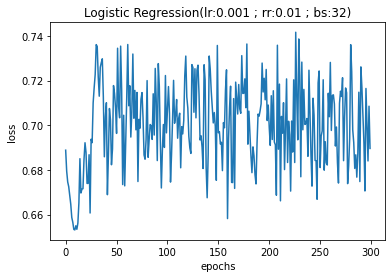

(0.6754176610978521, 0.6237623762376238, 0.8957345971563981, 0.7354085603112841)


In [ ]:
data_train, labels_train, data_validation, labels_validation = create_trucksplanes_dataset()
accuracy, hyperparameters = train_a_model(data_train, labels_train, data_validation, labels_validation,\
                  learning_rate = 1e-3, regularization_rate = 0.01, batch_size = 32, epoch = 300)

In [ ]:
print(accuracy)
print(hyperparameters)

0.6754176610978521
{'learning_rate': 0.001, 'regularization_rate': 0.01, 'batch_size': 32, 'epoch': 300}


##Hyperparameter Search

In [ ]:
def hyperparameter_search(data_train, labels_train, data_validation, labels_validation):
    """
    """
    best_hyperparameters = {
            "learning_rate": 0.0,
            "regularization_rate": 0.0,
            "batch_size": 1,
            "epoch":0
            }
    best_accuracy_so_far = 0.0
    num_features = data_train.shape[1]

    ## YOUR CODE HERE
    # Fill the following lists with the hyperparameters you intend to try.
    learning_rates = [0.1, 0.001, 1e-3] #1e-3 = 1*10^(-3) = 0.0001
    regularizations = [0.1, 0.01, 0.001]
    batch_sizes = [16, 32, 64]
    epochs = [100]
    ## END YOUR CODE

    print("### STARTING HYPERPARAMETER SEARCH ###")
    for params in product(learning_rates, regularizations, batch_sizes, epochs):
        ## YOUR CODE HERE
        # Hint: create a LogisticRegression object with the given hyperparameters.
        # Train and store the best score so far and best hyperparameters.
        # Compute the accuracy score using compute_accuracy in the LogisticRegression class!
        learning_rate, regularization_rate, batch_size, epoch = params
        accuracy, hyperparameters = train_a_model(data_train, labels_train, data_validation, labels_validation,
                  learning_rate, regularization_rate, batch_size, epoch)
        print(f"learning rate: {learning_rate}, regularization_rate: {regularization_rate}, batch_size: {batch_size}")
        print(f"=========Accuracy: {accuracy}=========")
        if accuracy > best_accuracy_so_far:
          best_accuracy_so_far = accuracy
          best_hyperparameters = hyperparameters
        ## END YOUR CODE
    print("### FINISHED HYPERPARAMETER SEARCH ###")
    return best_hyperparameters

### STARTING HYPERPARAMETER SEARCH ###
Epoch: 10/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


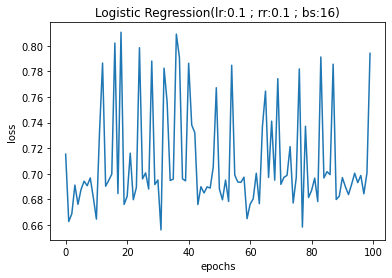

learning rate: 0.1, regularization_rate: 0.1, batch_size: 16
=========Accuracy: 0.5393794749403341=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


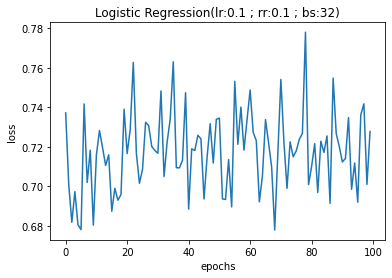

learning rate: 0.1, regularization_rate: 0.1, batch_size: 32
=========Accuracy: 0.6229116945107399=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


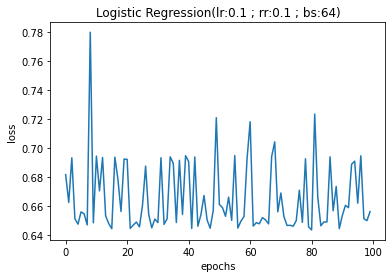

learning rate: 0.1, regularization_rate: 0.1, batch_size: 64
=========Accuracy: 0.6229116945107399=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


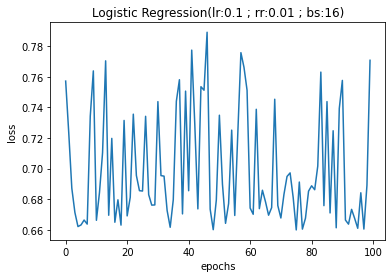

learning rate: 0.1, regularization_rate: 0.01, batch_size: 16
=========Accuracy: 0.5536992840095465=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


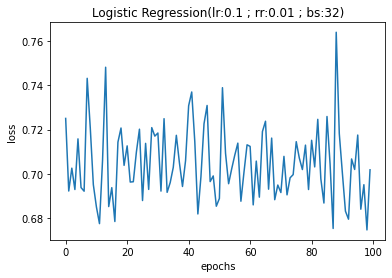

learning rate: 0.1, regularization_rate: 0.01, batch_size: 32
=========Accuracy: 0.6443914081145584=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


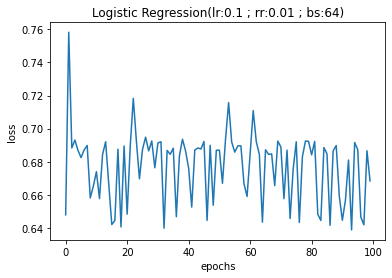

learning rate: 0.1, regularization_rate: 0.01, batch_size: 64
=========Accuracy: 0.5847255369928401=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


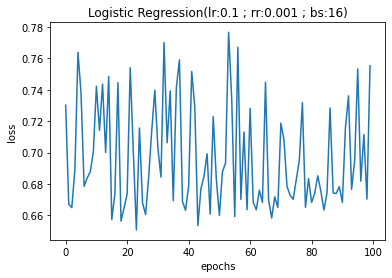

learning rate: 0.1, regularization_rate: 0.001, batch_size: 16
=========Accuracy: 0.5871121718377088=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


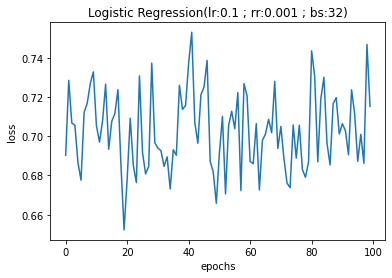

learning rate: 0.1, regularization_rate: 0.001, batch_size: 32
=========Accuracy: 0.6205250596658711=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


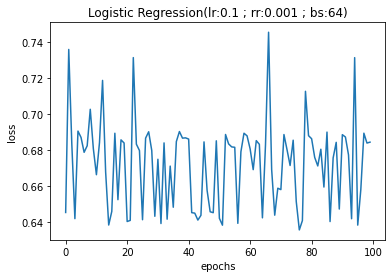

learning rate: 0.1, regularization_rate: 0.001, batch_size: 64
=========Accuracy: 0.5298329355608592=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


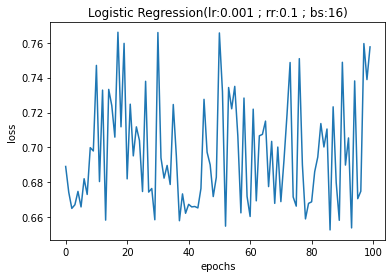

learning rate: 0.001, regularization_rate: 0.1, batch_size: 16
=========Accuracy: 0.5823389021479713=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


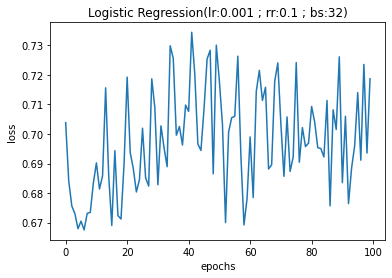

learning rate: 0.001, regularization_rate: 0.1, batch_size: 32
=========Accuracy: 0.6443914081145584=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


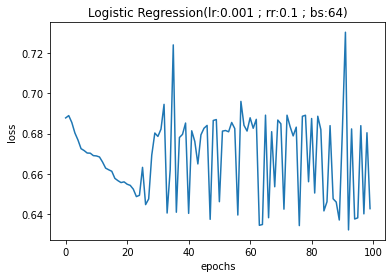

learning rate: 0.001, regularization_rate: 0.1, batch_size: 64
=========Accuracy: 0.6682577565632458=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


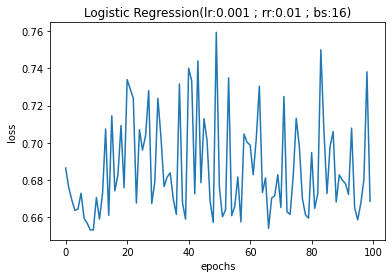

learning rate: 0.001, regularization_rate: 0.01, batch_size: 16
=========Accuracy: 0.6945107398568019=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


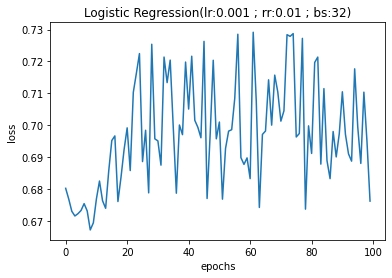

learning rate: 0.001, regularization_rate: 0.01, batch_size: 32
=========Accuracy: 0.6921241050119332=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


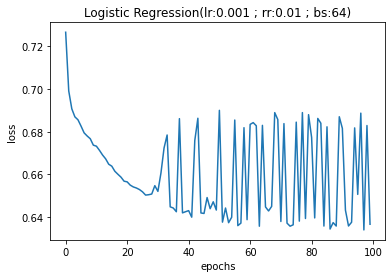

learning rate: 0.001, regularization_rate: 0.01, batch_size: 64
=========Accuracy: 0.665871121718377=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


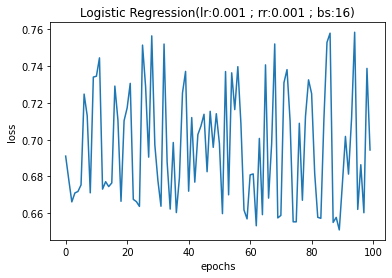

learning rate: 0.001, regularization_rate: 0.001, batch_size: 16
=========Accuracy: 0.6682577565632458=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


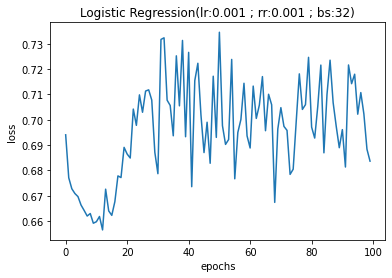

learning rate: 0.001, regularization_rate: 0.001, batch_size: 32
=========Accuracy: 0.6873508353221957=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


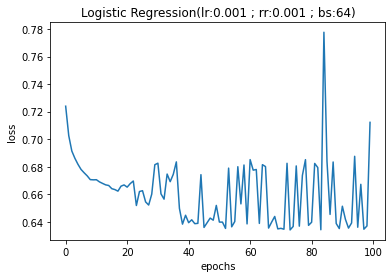

learning rate: 0.001, regularization_rate: 0.001, batch_size: 64
=========Accuracy: 0.6539379474940334=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


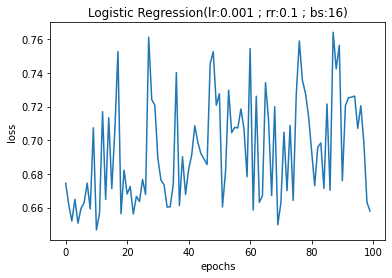

learning rate: 0.001, regularization_rate: 0.1, batch_size: 16
=========Accuracy: 0.6109785202863962=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


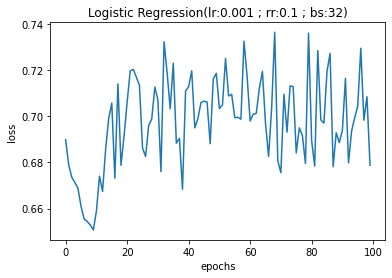

learning rate: 0.001, regularization_rate: 0.1, batch_size: 32
=========Accuracy: 0.7016706443914081=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


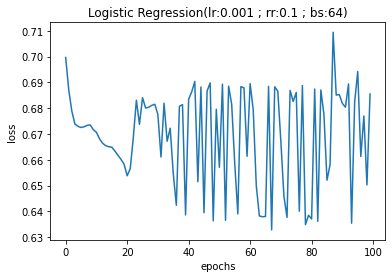

learning rate: 0.001, regularization_rate: 0.1, batch_size: 64
=========Accuracy: 0.5298329355608592=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


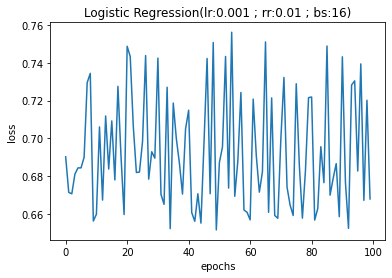

learning rate: 0.001, regularization_rate: 0.01, batch_size: 16
=========Accuracy: 0.6706443914081146=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


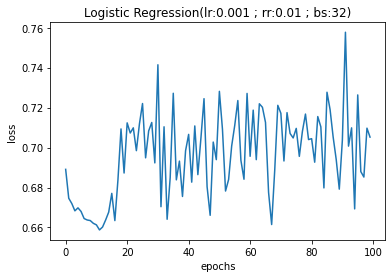

learning rate: 0.001, regularization_rate: 0.01, batch_size: 32
=========Accuracy: 0.6515513126491647=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


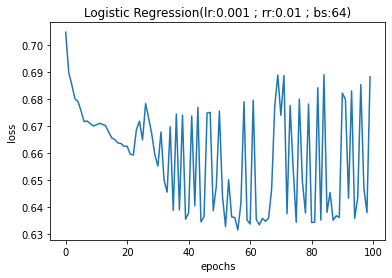

learning rate: 0.001, regularization_rate: 0.01, batch_size: 64
=========Accuracy: 0.5107398568019093=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


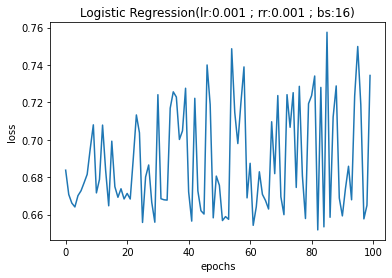

learning rate: 0.001, regularization_rate: 0.001, batch_size: 16
=========Accuracy: 0.60381861575179=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


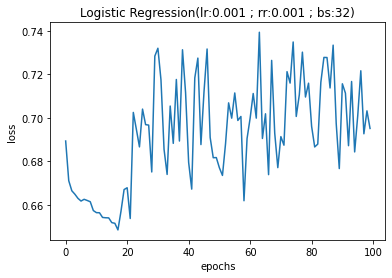

learning rate: 0.001, regularization_rate: 0.001, batch_size: 32
=========Accuracy: 0.6634844868735084=========
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


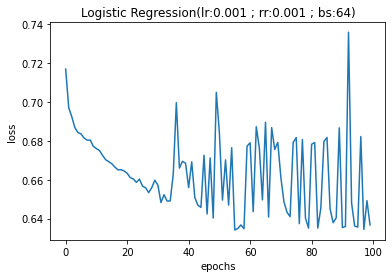

learning rate: 0.001, regularization_rate: 0.001, batch_size: 64
=========Accuracy: 0.7350835322195705=========
### FINISHED HYPERPARAMETER SEARCH ###


In [ ]:
best_trucks_and_planes_hyperparameters = hyperparameter_search(data_train, labels_train, data_validation, labels_validation)

In [ ]:
best_trucks_and_planes_hyperparameters

{'batch_size': 64,
 'epoch': 100,
 'learning_rate': 0.001,
 'regularization_rate': 0.001}

##Final Model with the Best Hyperparameter

Epoch: 10/100
Epoch: 21/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


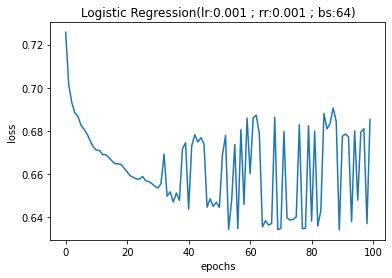

0.5298329355608592


In [ ]:
# data_train, labels_train, data_validation, labels_validation = create_trucksplanes_dataset()
#np.random.seed(0)

num_features = data_train.shape[1]

batch_size = best_trucks_and_planes_hyperparameters["batch_size"]
epoch = best_trucks_and_planes_hyperparameters["epoch"]
learning_rate = best_trucks_and_planes_hyperparameters["learning_rate"]
regularization_rate = best_trucks_and_planes_hyperparameters["regularization_rate"]

accuracy, hyperparameters = train_a_model(data_train, labels_train, data_validation, labels_validation,\
                  learning_rate = learning_rate, regularization_rate = regularization_rate,\
                  batch_size = batch_size, epoch = epoch)
print(accuracy)

#Classifying Poverty

Now it's time to see how our techniques perform for mapping poverty!

As Team Feature, your main task is to explore the effect of different features on the model performance.

##Load Data

In [ ]:
#Load Data
with h5py.File(
    os.path.join(ROOT_DIR, "data/assorted_images/satellite_images.h5"),
    "r") as hf:
  X_satel = hf["data"][...] / 255. #image
  y_satel = hf["labels"][...] #label

np.random.seed(0)
assign = np.random.permutation(len(X_satel))
satel_cutoff = int(0.8 * len(X_satel))
satel_train_assign = assign[:satel_cutoff]
satel_test_assign = assign[satel_cutoff:]

##Task 1: Load Different Features



We provide a set of pre-calculated features. This set of features is more sophisticated than histograms. There are four options in the "./data/features" folder:


1.   "./data/features/transfer_features.npy" is calculated by a specific learning algorithm called transfer learning
2.   "./data/features/imagenet_features.npy" is calculated by a convolutional neural network pretrained on the ImageNet dataset
3.   "./data/features/nightlight_features.npy" is the nigh light features extracted from the satellite images
4.   "./data/features/survey_features.npy" is the features extracted from the survey data



In [ ]:
#Load Pre-calculated Features
def extract_uganda_features(path, test):
    H = np.load(os.path.join(ROOT_DIR, path))
    uga_mean = H.mean(axis=0)
    uga_std = H.std(axis=0)
    H -= uga_mean
    H /= (uga_mean + 1e-8)
    H = np.column_stack([H,np.ones(len(H))])
    if not test:
      return H[satel_train_assign]
    else:
      return H[satel_test_assign]

def load_satellite_labels(test):
    if not test:
      return y_satel[satel_train_assign][...,None]
    else:
      return y_satel[satel_test_assign][...,None]

##Task 2: Train A Model

Using different features, histograms and pre-calculated, train models with fixed hyperparameters. Compare the results.

In [ ]:
def find_feature_train(data_train, labels_train, data_validation, labels_validation, test_labels, test_features):
  accuracy, hyperparameters = train_a_model(data_train, labels_train, data_validation, labels_validation,\
                  learning_rate = 0.1, regularization_rate = 0.01, batch_size = 32, epoch = 100)
  return accuracy, hyperparameters

In [ ]:
def create_uganda_dataset(pathy):
    print("### Extracting Uganda Dataset ###")

    # features
    features = extract_uganda_features(path = pathy, test = False)
    test_features = extract_uganda_features(path = pathy, test = True)

    # labels
    labels = load_satellite_labels(test = False)
    test_labels = load_satellite_labels(test = True)

    features, labels = shuffle_data(features, labels)

    data_train, labels_train, data_validation, labels_validation = split_dataset(features, labels)

    return data_train, labels_train, data_validation, labels_validation, test_labels, test_features

In [ ]:
def feature_search():
  feature_path_list = ['./data/features/transfer_features.npy', './data/features/imagenet_features.npy', 
                       './data/features/nightlight_features.npy'] #'./data/features/survey_features.npy']
  best_accuracy = 0.0
  best_path = None

  for i in feature_path_list:
    data_train, labels_train, data_validation, labels_validation, test_labels, test_features = create_uganda_dataset(pathy=i)
    
    data_train = np.concatenate((data_train, np.ones((data_train.shape[0],1))), axis = 1)
    data_validation = np.concatenate((data_validation, np.ones((data_validation.shape[0],1))), axis = 1)

    accuracy, hyperparameters = find_feature_train(data_train, labels_train, data_validation, labels_validation, test_labels, test_features)
    
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_path = i

    print('accuracy = ', accuracy)
  print('best accuracy = ', best_accuracy)
  print('best path = ', best_path)

  return best_accuracy, best_path

### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


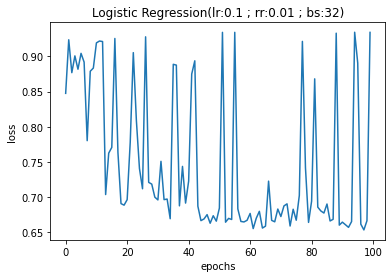

(0.4423076923076923, 0.24324324324324326, 0.9, 0.3829787234042553)
accuracy =  0.4423076923076923
### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


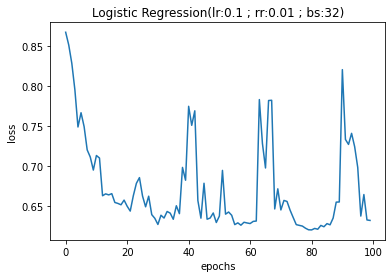

(0.34615384615384615, 0.14705882352941177, 0.5, 0.22727272727272727)
accuracy =  0.34615384615384615
### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


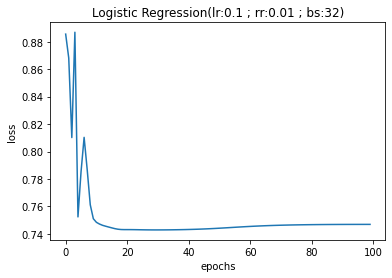

(0.8076923076923077, 0.0, 0.0, 0.0)
accuracy =  0.8076923076923077
best accuracy =  0.8076923076923077
best path =  ./data/features/nightlight_features.npy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
best_accuracy, best_path = feature_search()

In [ ]:
data_train, labels_train, data_validation, labels_validation, test_labels, test_features = create_uganda_dataset(pathy = best_path)
print("Uganda Dataset")
print("shape of training data: {}".format(np.shape(data_train)))
print("shape of validation data: {}".format(np.shape(data_validation)))
print("shape of test labels data: {}".format(np.shape(test_labels)))
print("shape of test training data: {}".format(np.shape(test_features)))

### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Uganda Dataset
shape of training data: (460, 72)
shape of validation data: (52, 72)
shape of test labels data: (129, 1)
shape of test training data: (129, 72)


In [ ]:
# accuracy, hyperparameters = train_a_model(data_train, labels_train, data_validation, labels_validation,\
#                   learning_rate = 0.1, regularization_rate = 0.01, batch_size = 32, epoch = 100)

##Task 3: Evaluate the Model with Different Metrics

1. In our toy example, we noticed that different random seed can affect the performance of our model. How can we address this problem.

  *Hint: Check out cross-validation.*

2. So far we have only evaluated our models in the validation set, now we should deploy it to the test set. Train your best model with the entire training set (i.e. union of the train split and the validation split in the training set) and test it on the test set.

3. We have provided various other metrics to evaluate the models in the **Training Essentials** section. Explore different metrics and discuss the meaning of each score.

  *Hint: Feel free to go back and change your code for Logistic Regression Model*

In [ ]:
#Kelly edit: instead of returning hyperparamters, we are returning models here
def train_a_model_f1(data_train, labels_train, data_validation, labels_validation,
                  learning_rate, regularization_rate, batch_size, epoch):
  hyperparameters = {
            "learning_rate": learning_rate,
            "regularization_rate": regularization_rate,
            "batch_size": batch_size,
            "epoch": epoch
            }
  
  num_features = data_train.shape[1]
  ## YOUR CODE HERE
  model = LogisticRegression(num_features, learning_rate, regularization_rate, batch_size, epoch)
  model.train(data_train, labels_train)
  # f1 = model.compute_f1(data_validation, labels_validation)
  #Kelly edit: all_scores = model.all_scores(...)
  all_scores = model.all_scores(data_validation, labels_validation)
  return all_scores, model
  #Kelly edit: return all_scores, hyperparameters

In [ ]:
def find_feature_train_f1(data_train, labels_train, data_validation, labels_validation, test_labels, test_features):
  all_scores, model = train_a_model_f1(data_train, labels_train, data_validation, labels_validation,\
                  learning_rate = 0.01, regularization_rate = 0.1, batch_size = 32, epoch = 100)
  #Kelly edit: all scores here as well
  return all_scores, model

In [ ]:
#CROSS-VAL SPLIT
def crossval():
  feature_path_list = ['./data/features/transfer_features.npy', './data/features/imagenet_features.npy', 
                       './data/features/nightlight_features.npy','./data/features/survey_features.npy']
  k = 10
  #8 brackets
  all_f1 = [[], [], [], [], [], [], [], []]
  all_acc = [[], [], [], [], [], [], [], []]
  all_precision = [[], [], [], [], [], [], [], []]
  all_recall = [[], [], [], [], [], [], [], []]

  #Kelly edit: you can have four lists like this

  for index, i in enumerate(feature_path_list):
      data_train, labels_train, data_validation, labels_validation, test_labels, test_features = create_uganda_dataset(pathy=i)

      data_combined = np.concatenate((data_train, data_validation), axis = 0)
      labels_combined = np.concatenate((labels_validation, labels_train), axis = 0)

      for x in range(k):
        data_validation = data_combined[x*(len(data_combined)//10):(x+1)*(len(data_combined)//10)]
        data_train = np.concatenate((data_combined[:x*(len(data_combined)//10)], data_combined[(x+1)*(len(data_combined)//10):]))
        
        data_train_no_bias = data_train
        data_validation_no_bias = data_validation

        data_train = np.concatenate((data_train, np.ones((data_train.shape[0],1))), axis = 1)
        data_validation = np.concatenate((data_validation, np.ones((data_validation.shape[0],1))), axis = 1)

        labels_validation = labels_combined[x*(len(labels_combined)//10):(x+1)*(len(labels_combined)//10)]
        labels_train = np.concatenate((labels_combined[:x*(len(labels_combined)//10)], labels_combined[(x+1)*(len(labels_combined)//10):])) 

        (accuracy, precision, recall, f1), model = find_feature_train_f1(data_train, labels_train, data_validation, labels_validation, test_labels, test_features)
        
        (accuracy_nb, precision_nb, precision_nb, f1_nb), model = find_feature_train_f1(data_train_no_bias, labels_train, data_validation_no_bias, labels_validation, test_labels, test_features)

        #Kelly edit: all scores here: acc, precision, recall, f1 = ...
        #Kelly edit: all_acc[index].append(acc)
        #Kelly edit: ...
        
# With Bias
        all_f1[index].append(f1)
        all_acc[index].append(accuracy)
        all_precision[index].append(precision)
        all_recall[index].append(recall)

# Without Bias
        all_f1[index + 4].append(f1_nb)
        all_acc[index + 4].append(accuracy_nb)
        all_precision[index + 4].append(precision_nb)
        all_recall[index + 4].append(precision_nb)

  return all_f1, all_acc, all_precision, all_recall

### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


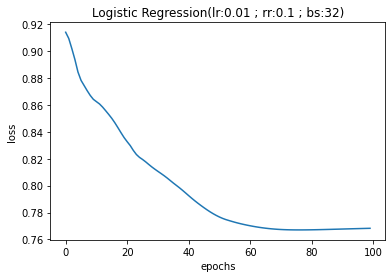

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


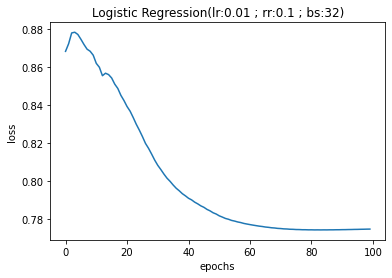

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


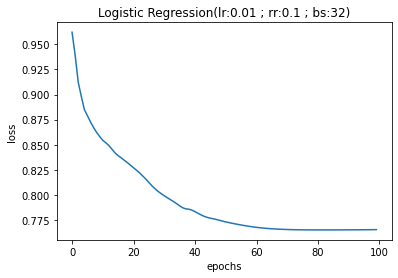

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


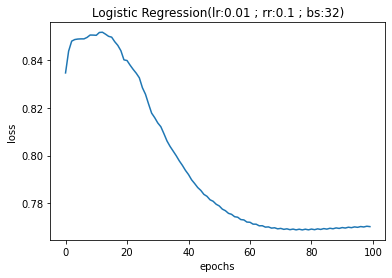

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


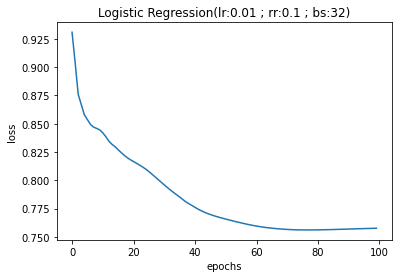

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


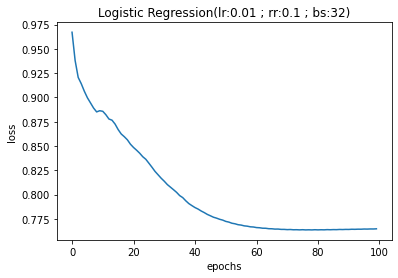

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


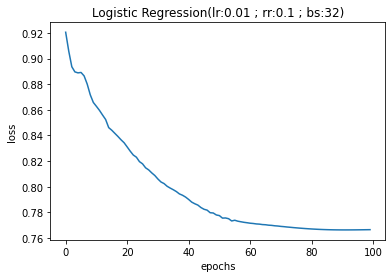

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


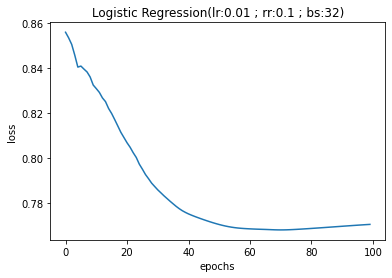

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


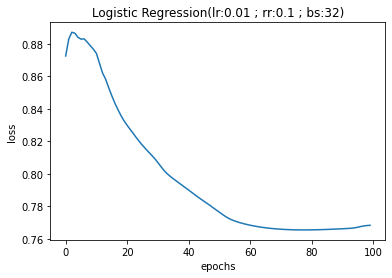

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


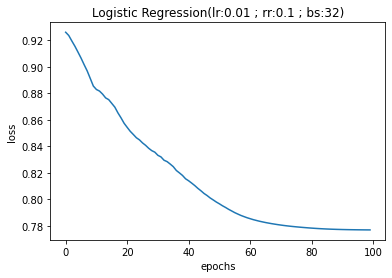

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


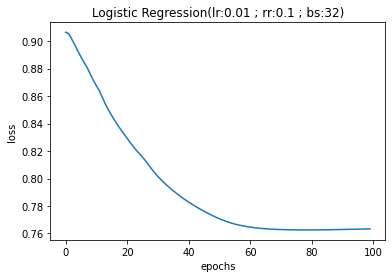

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


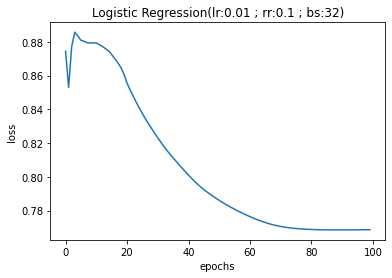

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


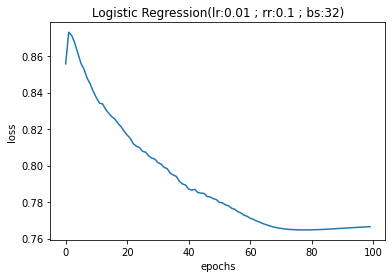

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


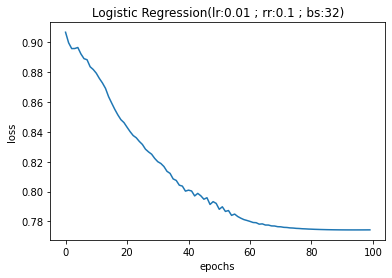

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


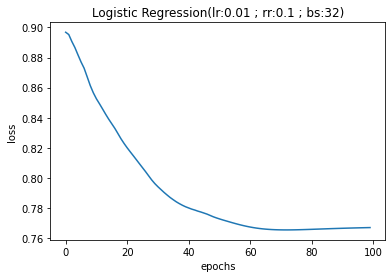

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


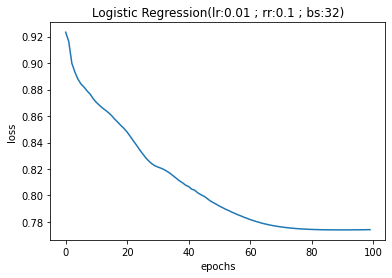

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


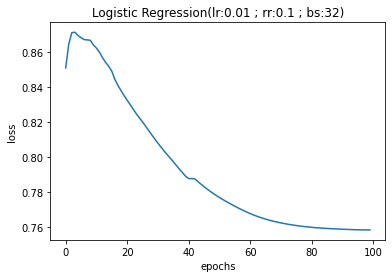

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


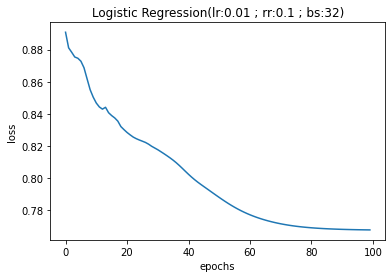

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


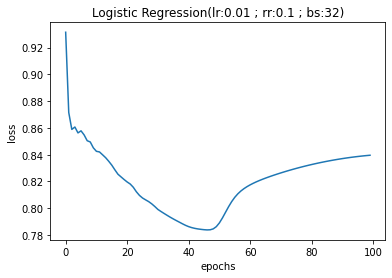

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


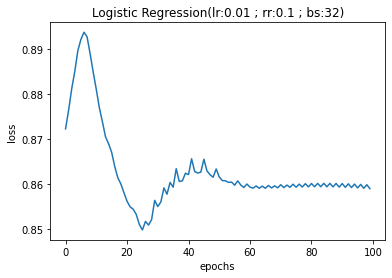

### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


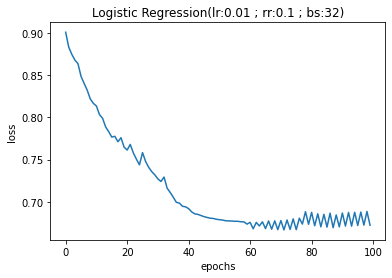

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


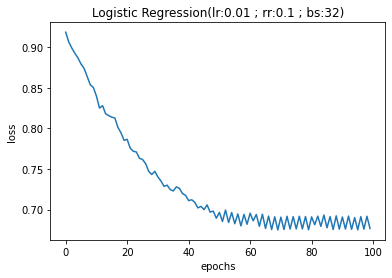

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


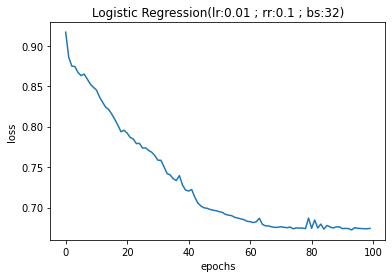

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


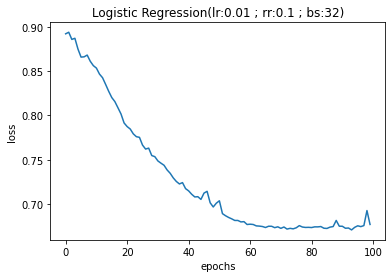

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


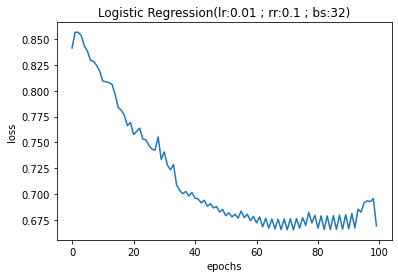

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


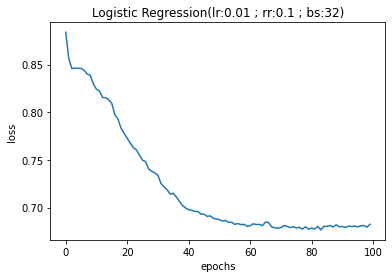

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


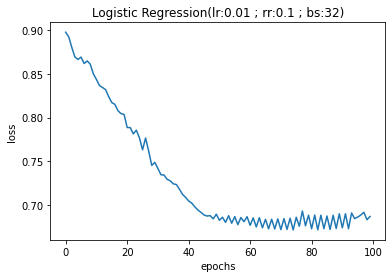

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


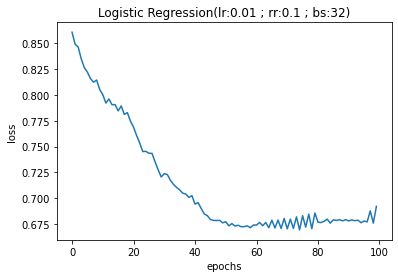

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


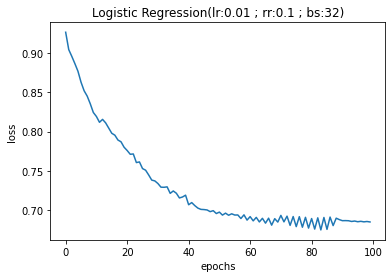

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


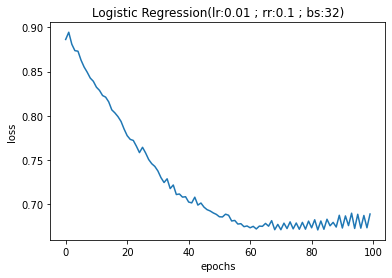

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


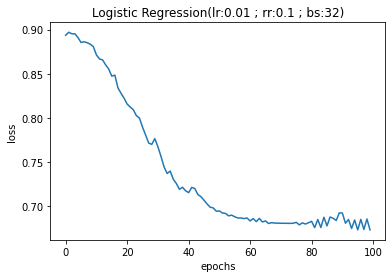

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


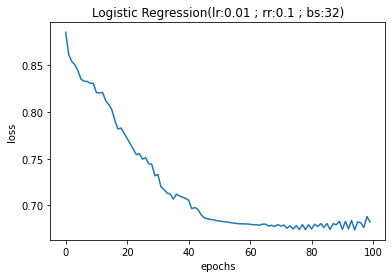

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


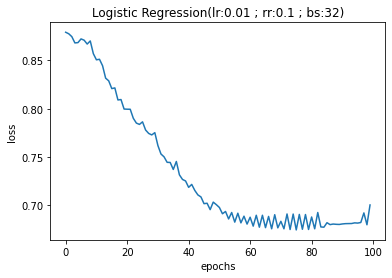

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


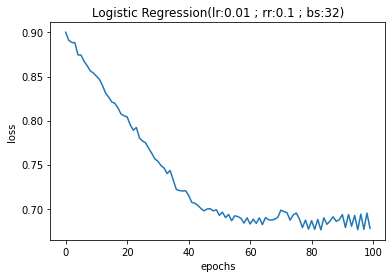

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


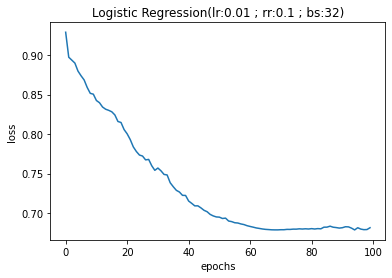

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


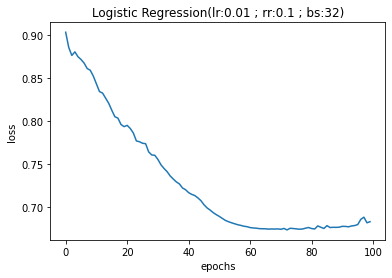

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


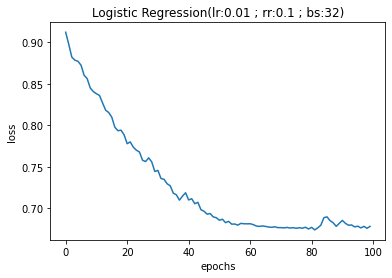

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


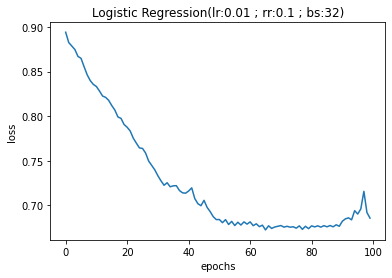

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


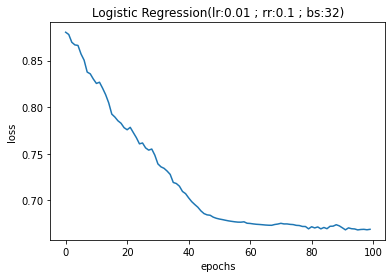

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


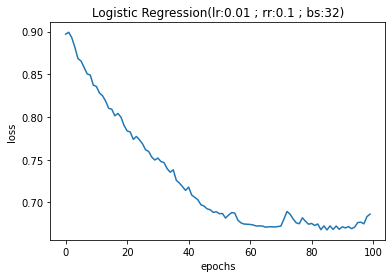

### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


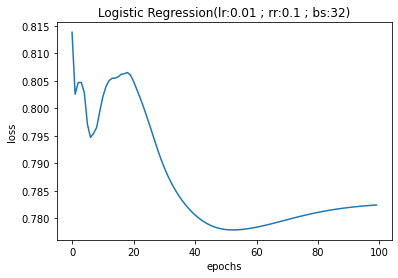

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


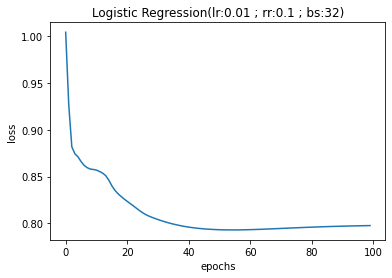

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


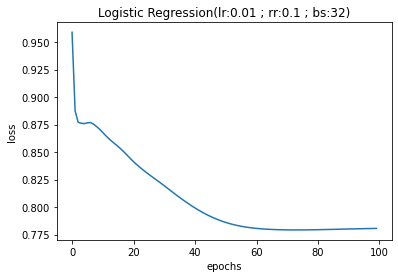

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


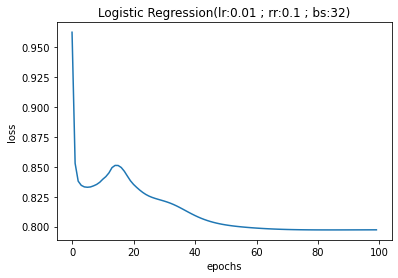

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


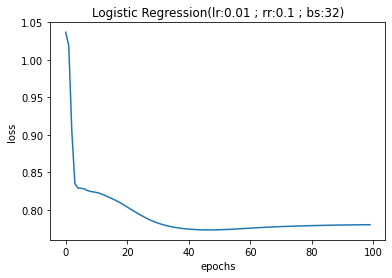

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


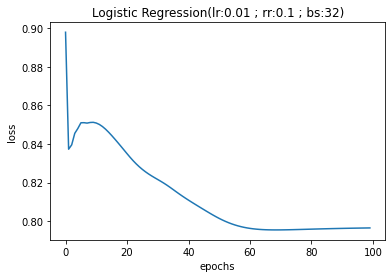

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


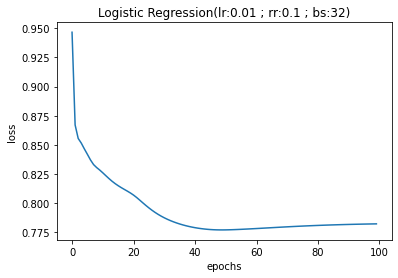

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


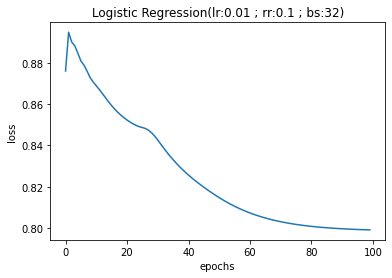

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


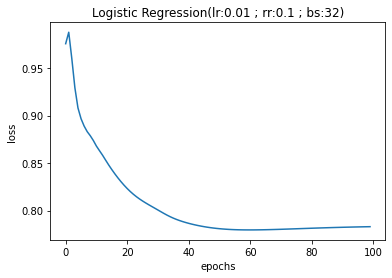

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


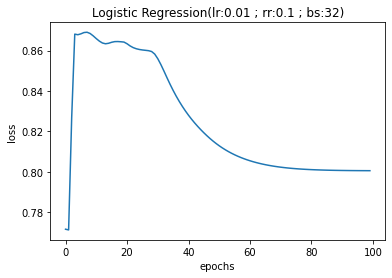

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


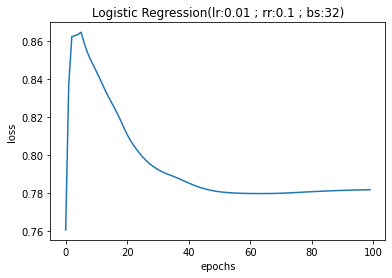

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


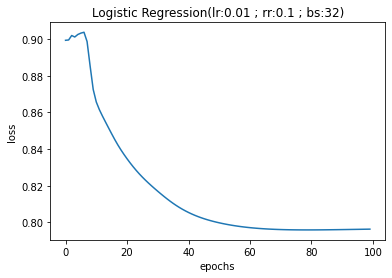

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


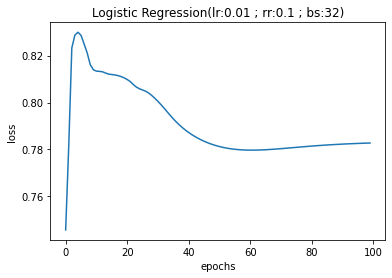

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


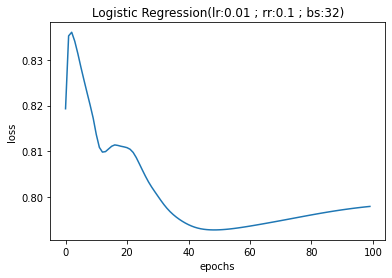

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


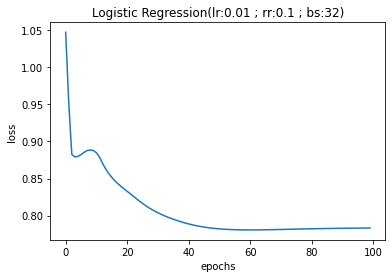

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


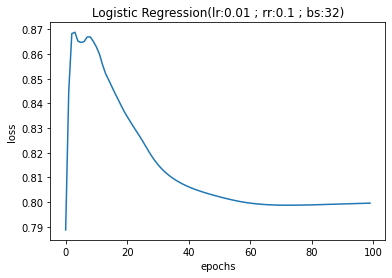

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


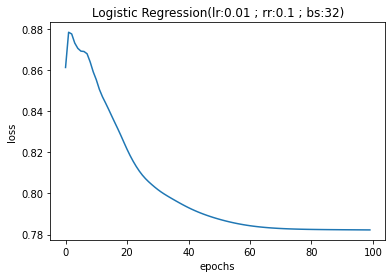

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


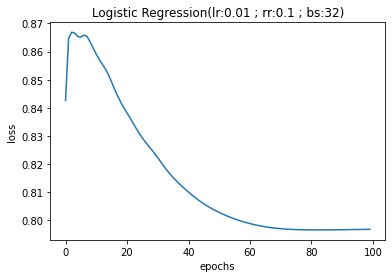

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


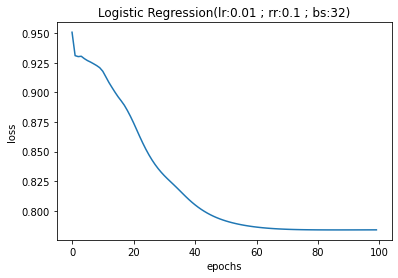

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


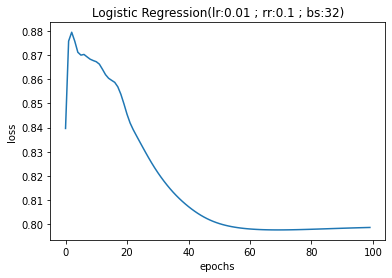

### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


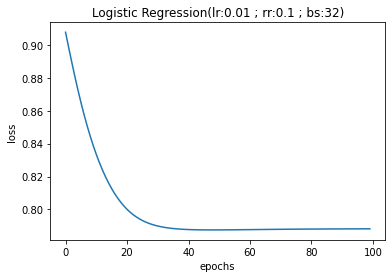

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


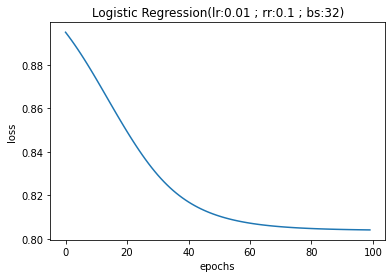

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


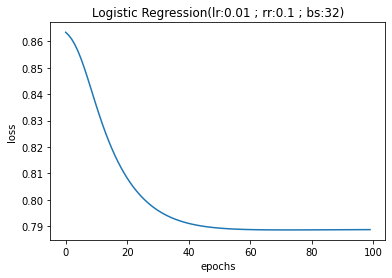

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


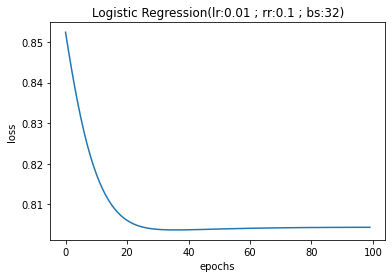

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


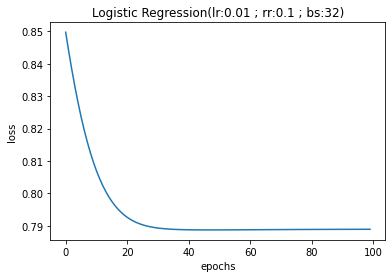

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


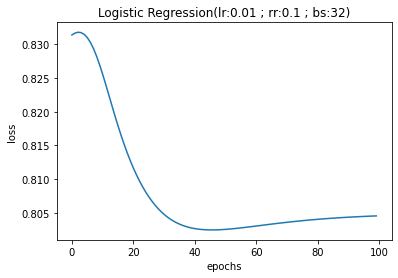

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


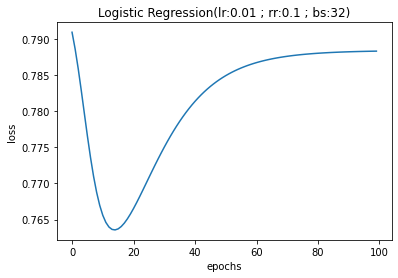

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


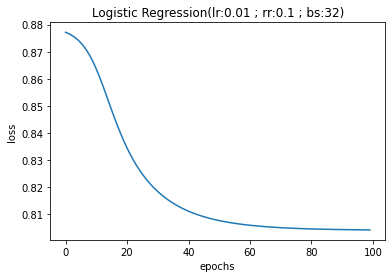

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


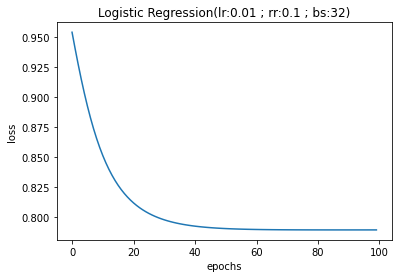

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


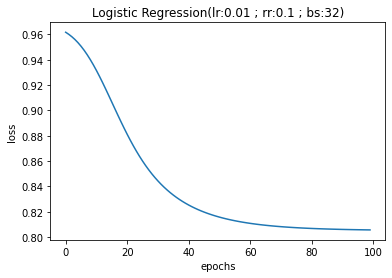

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


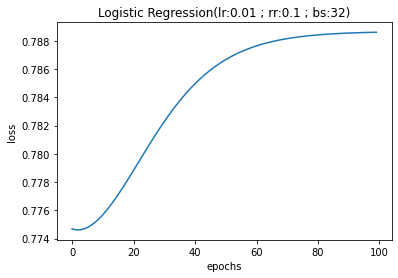

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


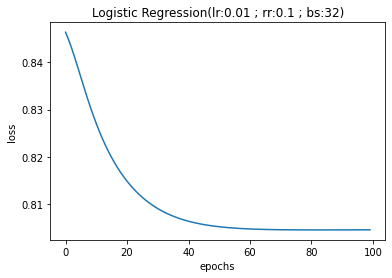

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


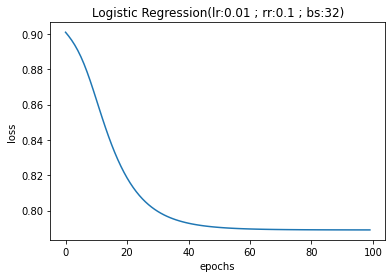

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


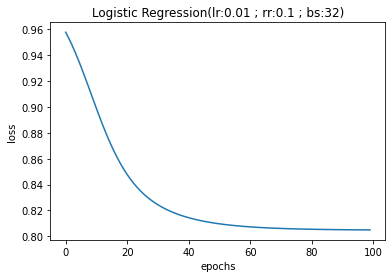

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


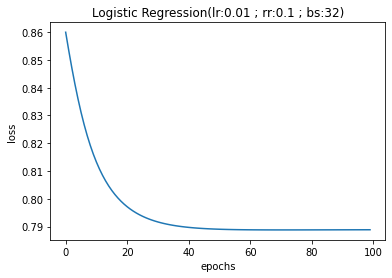

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


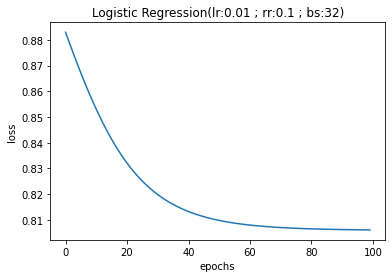

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


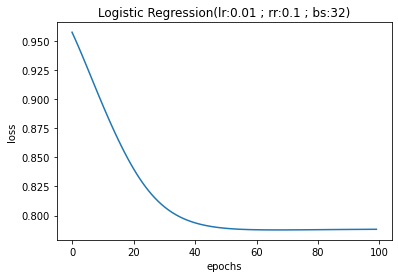

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


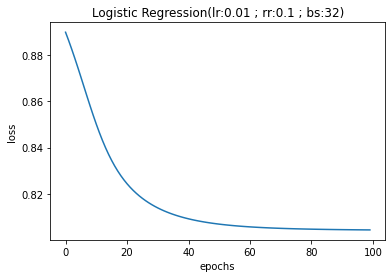

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


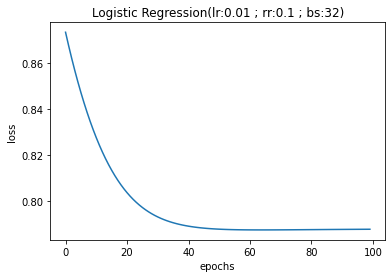

Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


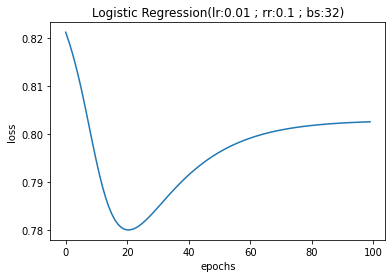

In [ ]:
all_f1, all_acc, all_precision, all_recall = crossval()

In [ ]:
print(all_f1)
print(np.asarray(all_f1).shape)
all_f1 = np.asarray(all_f1)

[[0.33333333333333326, 0.1818181818181818, 0.16666666666666666, 0.10526315789473685, 0.3636363636363636, 0.22222222222222224, 0.1111111111111111, 0.21428571428571427, 0.2222222222222222, 0.10526315789473685], [0.14285714285714285, 0.37037037037037035, 0.3125, 0.08333333333333333, 0.41379310344827586, 0.29411764705882354, 0.23076923076923075, 0.48648648648648646, 0.14285714285714285, 0.24], [0.18181818181818182, 0.14285714285714288, 0.0, 0.0, 0.14285714285714285, 0.10526315789473685, 0.0, 0.0909090909090909, 0.09999999999999999, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.4210526315789474, 0.0909090909090909, 0.15384615384615383, 0.09523809523809525, 0.380952380952381, 0.35714285714285715, 0.19999999999999998, 0.27586206896551724, 0.21428571428571427, 0.15000000000000002], [0.13333333333333333, 0.3125, 0.3225806451612903, 0.08333333333333333, 0.3870967741935484, 0.358974358974359, 0.3636363636363636, 0.47058823529411764, 0.24242424242424246, 0.25], [0.0, 0.1333333333333

In [ ]:
best_mean = 0.0
best_feature = None
feature_path_list = ['./data/features/transfer_features.npy', './data/features/imagenet_features.npy', 
                       './data/features/nightlight_features.npy', './data/features/survey_features.npy']

for i in range(len(feature_path_list)): # changed from all_f1.shape[0]
  mean = np.mean(all_f1[i])
  print(mean)

  if mean > best_mean:
    best_mean = mean
    best_features = feature_path_list[i]

print(best_mean, best_features)

0.20258221310852886
0.2717084457180806
0.07637047163362952
0.0
0.2717084457180806 ./data/features/imagenet_features.npy


In [ ]:
# Kelly edit: 
feature_path_list = ['./data/features/transfer_features.npy', './data/features/imagenet_features.npy', 
                       './data/features/nightlight_features.npy', './data/features/survey_features.npy']

feature_list = ["Transfer w/ Bias","ImageNet w/ Bias", "NightLight w/ Bias", "Survey w/ Bias", 
                "Transfer w/o Bias","ImageNet w/o Bias", "NightLight w/o Bias", "Survey w/o Bias"]

all_acc = np.asarray(all_acc)
all_f1 = np.asarray(all_f1)
all_precision = np.asarray(all_precision)
all_recall = np.asarray(all_recall)

for i in range(all_acc.shape[0]):
  mean = np.mean(all_acc[i])
  print("Acc:", feature_list[i], mean)


for i in range(all_f1.shape[0]):
  mean = np.mean(all_f1[i])
  print("F1:", feature_list[i], mean)


for i in range(all_precision.shape[0]):
  mean = np.mean(all_precision[i])
  print("Precision:", feature_list[i], mean)


for i in range(all_recall.shape[0]):
  mean = np.mean(all_recall[i])
  print("Recall:", feature_list[i], mean)

Acc: Transfer w/ Bias 0.6176470588235292
Acc: ImageNet w/ Bias 0.592156862745098
Acc: NightLight w/ Bias 0.7313725490196079
Acc: Survey w/ Bias 0.7803921568627452
Acc: Transfer w/o Bias 0.6156862745098037
Acc: ImageNet w/o Bias 0.5627450980392157
Acc: NightLight w/o Bias 0.7156862745098038
Acc: Survey w/o Bias 0.7803921568627452
F1: Transfer w/ Bias 0.20258221310852886
F1: ImageNet w/ Bias 0.2717084457180806
F1: NightLight w/ Bias 0.07637047163362952
F1: Survey w/ Bias 0.0
F1: Transfer w/o Bias 0.23392889929187569
F1: ImageNet w/o Bias 0.29244672863505883
F1: NightLight w/o Bias 0.07035714285714285
F1: Survey w/o Bias 0.0
Precision: Transfer w/ Bias 0.2087044989061118
Precision: ImageNet w/ Bias 0.22411849588320173
Precision: NightLight w/ Bias 0.22039682539682537
Precision: Survey w/ Bias 0.0
Precision: Transfer w/o Bias 0.2635077667430608
Precision: ImageNet w/o Bias 0.4251107715813599
Precision: NightLight w/o Bias 0.051639928698752224
Precision: Survey w/o Bias 0.0
Recall: Transfer

### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


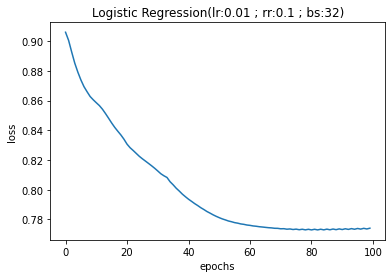

./data/features/transfer_features.npy without bias (0.5968992248062015, 0.0, 0.0, 0.0)
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


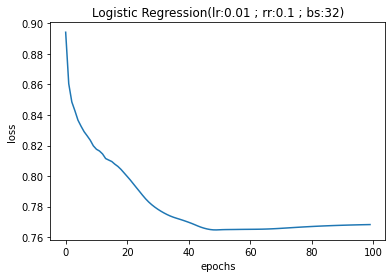

./data/features/transfer_features.npy with bias (0.5891472868217055, 0.0, 0.0, 0.0)
### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


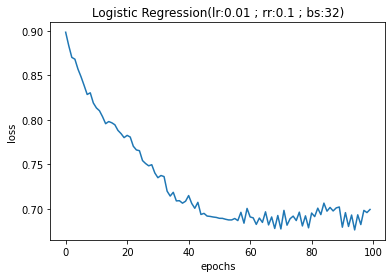

./data/features/imagenet_features.npy without bias (0.5271317829457365, 0.13725490196078433, 0.2916666666666667, 0.18666666666666668)
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


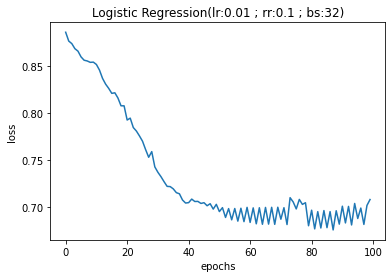

./data/features/imagenet_features.npy with bias (0.6046511627906976, 0.15384615384615385, 0.25, 0.1904761904761905)
### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


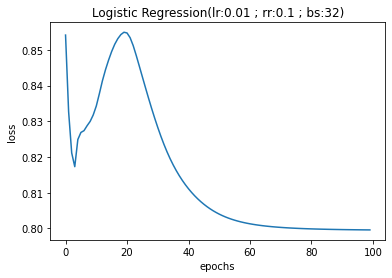

./data/features/nightlight_features.npy without bias (0.7131782945736435, 0.0, 0.0, 0.0)
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


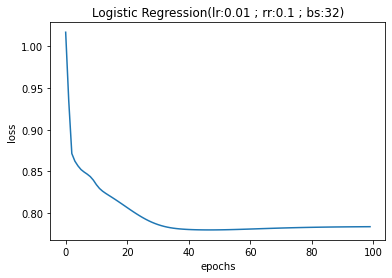

./data/features/nightlight_features.npy with bias (0.7596899224806202, 0.0, 0.0, 0.0)
### Extracting Uganda Dataset ###
Training data has 460 examples, validation data has 52 examples
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


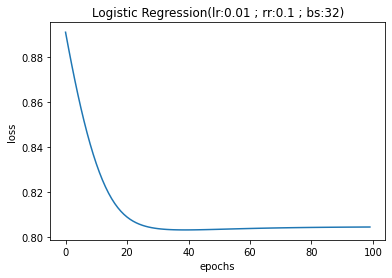

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


./data/features/survey_features.npy without bias (0.813953488372093, 0.0, 0.0, 0.0)
Epoch: 10/100
Epoch: 21/100
Epoch: 32/100
Epoch: 43/100
Epoch: 54/100
Epoch: 65/100
Epoch: 76/100
Epoch: 87/100
Epoch: 98/100


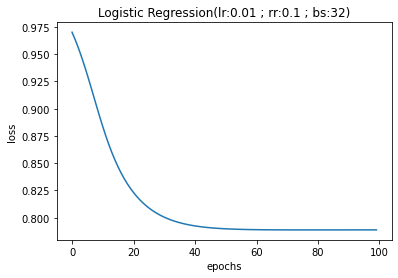

./data/features/survey_features.npy with bias (0.813953488372093, 0.0, 0.0, 0.0)


In [ ]:
trained_models = []
feature_path_list = ['./data/features/transfer_features.npy', './data/features/imagenet_features.npy', 
                       './data/features/nightlight_features.npy','./data/features/survey_features.npy']
feature_list = ["Transfer w/ Bias","ImageNet w/ Bias", "NightLight w/ Bias", "Survey w/ Bias", 
                "Transfer w/o Bias","ImageNet w/o Bias", "NightLight w/o Bias", "Survey w/o Bias"]

for index, i in enumerate(feature_path_list):
  data_train, labels_train, data_validation, labels_validation, test_labels, test_features = create_uganda_dataset(pathy=i)

  #without bias
  data_combined = np.concatenate((data_train, data_validation), axis = 0)
  labels_combined = np.concatenate((labels_validation, labels_train), axis = 0)
  #Kelly Edit: need changes below
  all_scores, model = train_a_model_f1(data_combined, labels_combined, test_features, test_labels,\
                    learning_rate = 0.01, regularization_rate = 0.1, batch_size = 32, epoch = 100)
  print(i, "without bias", all_scores)
  trained_models.append((feature_list[index+4], model, data_combined, labels_combined, test_features, test_labels))

  #with Bias
  data_combined = np.concatenate((data_combined, np.ones((data_combined.shape[0],1))), axis = 1)
  test_features = np.concatenate((test_features, np.ones((test_features.shape[0],1))), axis = 1)
  #Kelly Edit: need changes below
  all_scores, model = train_a_model_f1(data_combined, labels_combined, test_features, test_labels,\
                    learning_rate = 0.01, regularization_rate = 0.1, batch_size = 32, epoch = 100)
  print(i, "with bias", all_scores)
  trained_models.append((feature_list[index], model, data_combined, labels_combined, test_features, test_labels))

In [ ]:
all_scores(model, data, labels)

NameError: ignored

In [ ]:
#TO-DO: 
# Train  a model on this training set and evaluate it on the test set, 
# Retain the evaluation score (dictionary store?)

## Task 5: Mapping Poverty

The Final step is to run your model for each location we've surveyed in Uganda and predict its probability of poverty. Locations with higher probability of being impoverished are shown in red. How does your map predict to the labeled data and the baseline models?

In [ ]:
def get_locs():
    with open(
        os.path.join(ROOT_DIR, "./data/survey_data/uga_2011_locs.txt"),
        "r") as f:
      lines = f.readlines()
    lines = [list(map(float,(line.strip()).split(' '))) for line in lines]
    return np.array(lines)

def rotate(x, t):
    theta = np.radians(t)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(np.matrix('{} {}; {} {}'.format(c, -s, s, c)))
    return np.dot(x, R)

def change_range(x, newMin, newMax):
    #oldMax = x.max(); oldMin = x.min()
    oldMin = np.array([x[:,0].min(),x[:,1].min()])
    oldMax = np.array([x[:,0].max(),x[:,1].max()])

    oldRange = (oldMax - oldMin)
    newRange = (newMax - newMin)
    y = (((x - oldMin) * newRange) / oldRange) + newMin

    #y = newMax - y
    return y

In [ ]:
def uganda_map(trained_models):
    k = 25
    f, axs = plt.subplots(3,4, figsize=(k, k/2))
    img = Image.open(os.path.join(ROOT_DIR, "./data/sample_images/ugout.gif"))
    r, c = np.array(img).shape
    locs = get_locs()
    locs = rotate(locs, 95)
    locs = change_range(locs, np.array([60.,60.]), np.array([500.,500.]))
    # axs[0, 1:].axis('off')

    for i in range(3):
        if i == 0:
          axs[i][0].imshow(img)
          for j in range(1,4):
            axs[i][j].set_visible(False)
        else:
          for j in range(4):
            axs[i][j].imshow(img)

    for i, (model_name, model, data_combined, labels_combined, test_features, test_labels) in enumerate(trained_models):

        X = np.concatenate((data_combined, test_features))
        Y = np.concatenate((labels_combined, test_labels))
        #without bias
        data_combined = np.concatenate((data_train, data_validation), axis = 0)
        labels_combined = np.concatenate((labels_validation, labels_train), axis = 0)
        ## YOUR CODE HERE
        color = [0, 0, 0]
        poverty_predictions = model.predict(X)
        poverty_predictions = np.round(poverty_predictions.flatten())

        # print(poverty_predictions.shape)

        color = np.column_stack([poverty_predictions, np.zeros_like(poverty_predictions), np.zeros_like(poverty_predictions)])

        # print(color.shape, locs.shape)
        ## END YOUR CODE
        
        ind = i//2
        axs_ind = i%2+1
        print(i, ind, axs_ind)
        print(model_name)
        axs[axs_ind][ind].scatter(locs[:,0], locs[:,1], c=color)
        axs[axs_ind][ind].set_title(model_name)
        axs[axs_ind][ind].set_xticklabels([])
        axs[axs_ind][ind].set_yticklabels([])

    C = np.column_stack([Y, np.zeros_like(Y), np.zeros_like(Y)])
    axs[0][0].scatter(locs[:,0],locs[:,1],c= C)
    axs[0][0].set_title("Labels")
    axs[0][0].set_xticklabels([])
    axs[0][0].set_yticklabels([])
    plt.show()

0 0 1
Transfer w/o Bias
1 0 2
Transfer w/ Bias
2 1 1
ImageNet w/o Bias
3 1 2
ImageNet w/ Bias
4 2 1
NightLight w/o Bias
5 2 2
NightLight w/ Bias
6 3 1
Survey w/o Bias
7 3 2
Survey w/ Bias


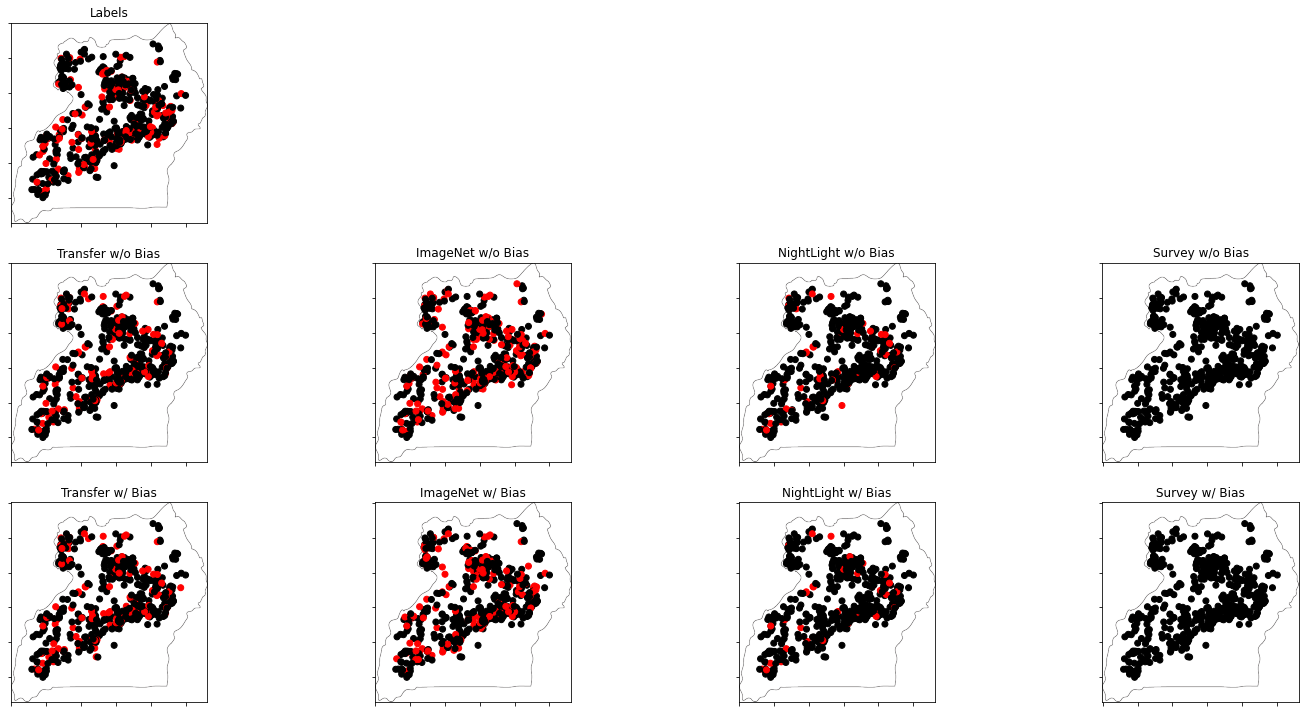

In [ ]:
uganda_map(trained_models)

*  Can you visualize the corresponding satellite images, locations, labels and predicted values of a given index of the data?

*  Can you put your code in two for loops to iterate and visualize all the data of correct and wrong predictions? 

*  Can you visualize the wrong predictions on the map?

##Task 4: Improve Your Results

Is your model overfitting? Why or why not? Is there any way to improve it?

Is there any other way to improve your results? E.g. instead of only using one type of features, can we combine different types of features in the modeling? Can we use other approaches to extract the features?